### Active Learning CEAL
This notebook demonstrates how an active learning approach leads to more effective training, by sampling uncertain samples for future training batches. The method used in this notebook is the [CEAL algorithm](https://arxiv.org/pdf/1711.09168.pdf), which involves the addition of highly-certain predicted samples to further accelerate training.

In [1]:
from abc import ABC, abstractmethod
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

C:\Users\Christian\Anaconda3\envs\deepsight\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Christian\Anaconda3\envs\deepsight\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Christian\Anaconda3\envs\deepsight\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Christian\Anaconda3\envs\deepsight\lib\s

In [2]:
class MultiClassClassifier(ABC):
    
    def __init__(self):
        self.model = self.get_compiled_model()
    
    @staticmethod
    @abstractmethod
    def get_compiled_model():
        pass
    
    @abstractmethod
    def get_training_sample(
        self,
        x: np.array,
        y: np.array,
        k: int,
    ) -> np.array:
        pass
    
    @abstractmethod
    def forward(
        self,
        x: np.array,
        y: np.array,
    ) -> None:
        pass
    
    @abstractmethod
    def predict(
        self,
        x: np.array,
    ) -> np.array:
        pass
    
    def evaluate(
        self, 
        x, 
        y,
    ):
        y_pred = np.apply_along_axis(
            lambda x: np.argmax(x),
            axis=1,
            arr=self.predict(x)
        )
        return (y_pred == y).mean()

In [3]:
class MultiClassClassifierSupervised(MultiClassClassifier):
    
    def get_training_sample(self, x, y, k):
        query = np.array(random.sample(
            range(x.shape[0]),
            k=k
        ))
        return x[query], y[query], query

In [4]:
class MultiClassClassifierActive(MultiClassClassifier):
    
    def get_training_sample(self, x, y, k):  
        preds = self.predict(x)
        query = np.apply_along_axis(
            lambda x: np.min(
                x[x[np.nonzero(x)].argsort()][-1] -
                    x[x[np.nonzero(x)].argsort()][-2]
            ), 
            axis=1, 
            arr=preds
        ).argsort()       
        y_pred = np.apply_along_axis(
            lambda x: np.argmax(x),
            axis=1,
            arr=preds
        )
        least = query[:k]
        most = query[np.max(preds, axis=1) > 0.95][-1:-k-1:-1]
        return (
            np.concatenate(
                (
                    x[least],
                    x[most],
                ),
                axis=0
            ), 
            np.concatenate(
                (
                    y[least],
                    y_pred[most],
                ),
                axis=0
            ), 
            least
       )
        

In [5]:
class Learner:
    
    def __init__(
        self,
        classifier,
        k=100,
        stop_acc=0.9,
    ):
        self.classifier = classifier
        self.k = k
        self.stop_acc = stop_acc
        self.steps = [0]
        self.accs = []
            
    def learn(
        self,
        x_train,
        y_train,
        x_test,
        y_test,
    ):
        while True:
            x, y, delete = self.classifier.get_training_sample(x_train, y_train, self.k)            
            self.classifier.forward(x, y)
            x_train, y_train = (
                np.delete(x_train, delete, axis=0),
                np.delete(y_train, delete, axis=0)
            )
            # In the case of active learning, the step
            # count is not representative of the total training
            # samples, but is indicative of the annotated samples,
            # as half of the labels are imputed by the model.
            self.steps.append(self.steps[-1] + self.k)
            self.accs.append(self.classifier.evaluate(x_test, y_test))
            if self.accs[-1] >= self.stop_acc:
                # Remove the first step bc we were
                # only using it for a counter.
                self.steps.pop(0)
                break

In [6]:
class KerasMNISTMultiClassClassifier:
    
    @staticmethod
    def get_compiled_model():
        model = tf.keras.Sequential(
            [
                tf.keras.layers.Flatten(input_shape=(28, 28)),
                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.Dense(10, activation='softmax'),
            ]
        )
        model.compile(
            optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )
        return model
    
    def forward(
        self,
        x: np.array,
        y: np.array,
    ) -> None:
        self.model.fit(
            x,
            y,
            epochs=1,
            verbose=0,
        )
    
    def predict(
        self,
        x: np.array,
    ) -> np.array:
        return self.model.predict(x)

In [7]:
class KerasMNISTMultiClassClassifierSupervised(
    KerasMNISTMultiClassClassifier, 
    MultiClassClassifierSupervised
):
    pass

In [8]:
class KerasMNISTMultiClassClassifierActive(
    KerasMNISTMultiClassClassifier,
    MultiClassClassifierActive
):
    pass

In [9]:
# Load and reformat MNIST dataset.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

In [10]:
# Supervised learning scenario.
supervised_classifier = KerasMNISTMultiClassClassifierSupervised()
supervised_learner = Learner(supervised_classifier)
supervised_learner.learn(x_train, y_train, x_test, y_test)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
# Active learning scenario.
active_classifier = KerasMNISTMultiClassClassifierActive()
active_learner = Learner(active_classifier)
active_learner.learn(x_train, y_train, x_test, y_test)

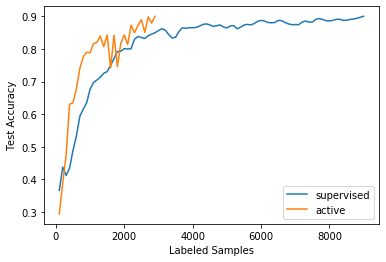

In [12]:
# Plot results.
plt.plot(supervised_learner.steps, supervised_learner.accs, label="supervised")
plt.plot(active_learner.steps, active_learner.accs, label="active")
plt.xlabel("Labeled Samples")
plt.ylabel("Test Accuracy")
plt.legend(loc="lower right")
plt.show()

It is demonstrable that with the active learning approach the model reaches .9 accuracy with approx 50% fewer labeled samples than under a supervised learning regime.